# CAmping Initiation - Data Wrangling & Exploration

This notebook is for exploring the preprocessed data.
This notebooks is implemented in the wrangle.py file.

In [11]:
# Get the notebook imports
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk import FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import MWETokenizer
from nltk.stem import LancasterStemmer
%matplotlib inline

plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams["xtick.labelsize"] = 20

Read in the preprocessed dataset. 

In [2]:
_data = pd.read_csv("PROCESSED_LABELED.csv")
_data.head()

,question_text,code
0,I know what my goals are and what I need to do...,ALI.5
1,I feel like I can be successful in my role,ALI.5
2,30. I know what I need to do to be successful ...,ALI.5
3,I understand my role and what is expected of me,ALI.5
4,I know what is expected of me in my role.,ALI.5


#### Class Distributions
The distribution of classes can make a significant impact on our machine learning algorithm. The result below shows that the class imbalance isn't too bad. It's not perfect, but for the purpose of the excercise we can atleast try our initial run without subsampling.

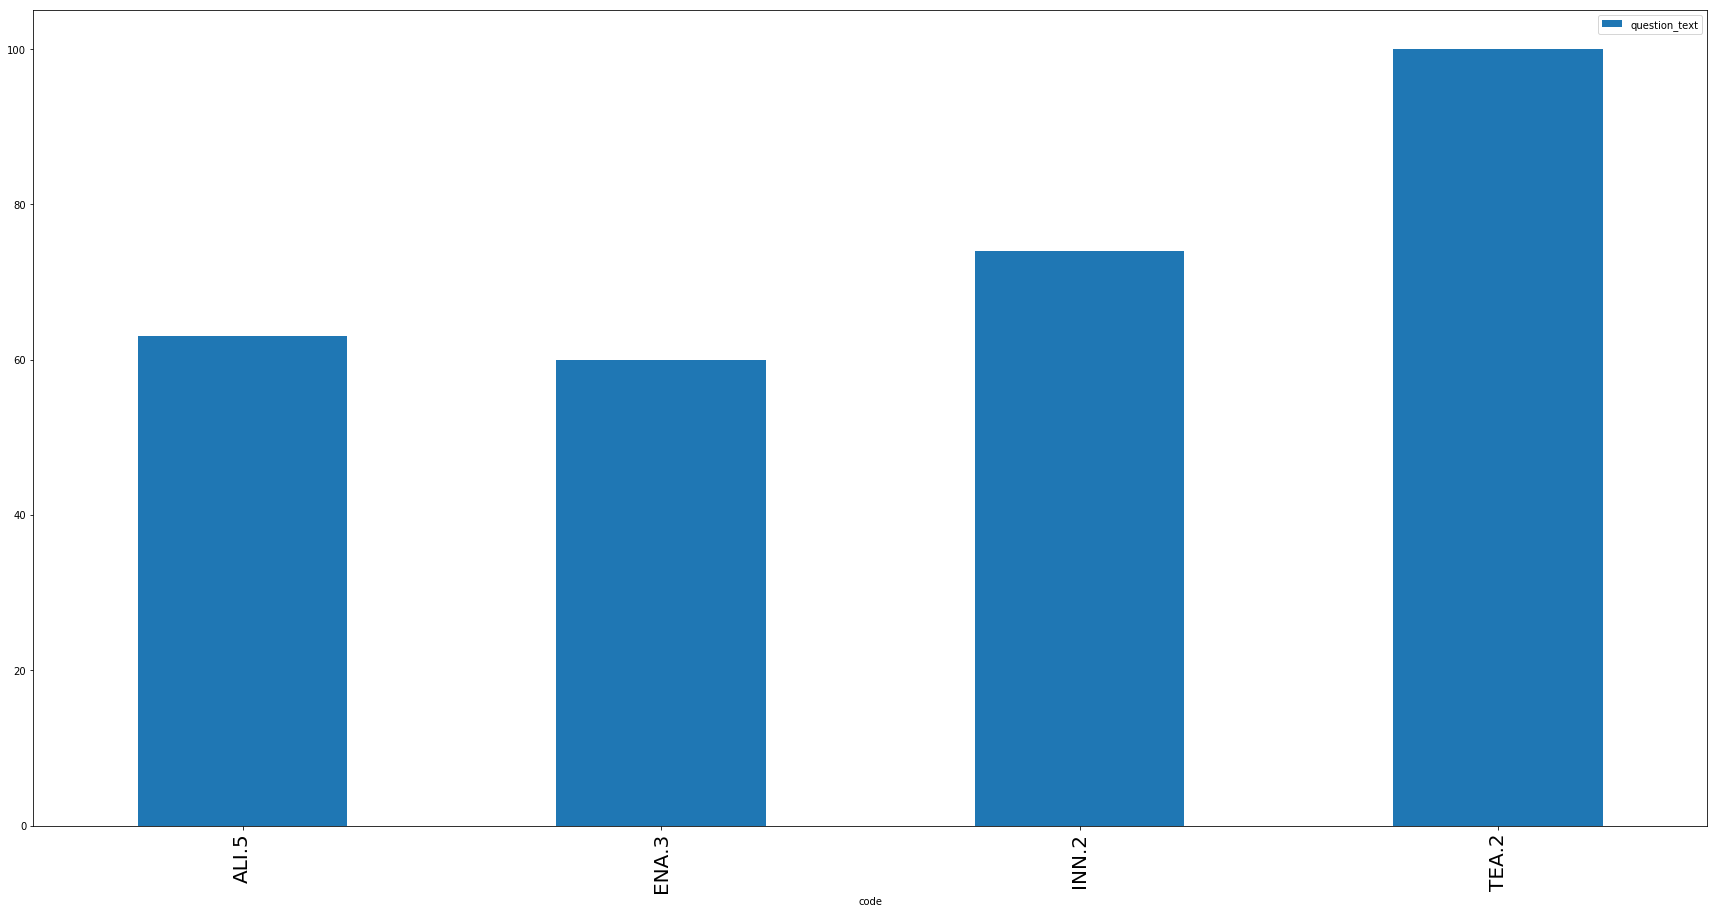

In [3]:
_data.groupby(['code']).count().reset_index().plot(kind='bar', x='code')
plt.show()

#### Text processing & exploration
Let's take some easy steps to have a look at our collection. First we will cast all items to lower case. We are assuming the the case of the letters has nothing to do with the class label. Given that it's a question, not an answer, probably not such a bad assumption.

In [4]:
_data['question_text'] = _data['question_text'].str.lower() # Assign it to self.

Let's tokenize our entire set. We probably should have split a training and testing set, but given that they gave us some test questions, we can use that as our test and validation set. 
Also, being realistic, we won't have time to do anything fancy, let's use a bag of words approach to modelling this system. We will also use a simple whitespace tokenizer to generate the bag of words too.

In [5]:
# Set up a helper function to take a string and a regex pattern then return the corresponding tokens in the string.
def getTokensFromString(string, regexPattern=r'\W+'):
    # type: (str,str) -> list
    """
    This method returns a list of tokens separated by whitespace.
    :param string: String to be tokenized.
    :param regexPattern: Regular expression pattern to tokenize on. Defaults to whitespace.
    :return: List containing the tokens.
    """

    _tokenizer = RegexpTokenizer(regexPattern, gaps=True)
    return _tokenizer.tokenize(string)

# Generate the wordbag
_wordBag = map(lambda x: getTokensFromString(x),_data['question_text'].tolist())

# When this is iterated over, it generates a list of lists, so let's flatten them out into one bag.
_flatBag = [word for wordList in list(_wordBag) for word in wordList]
len(_flatBag)

3548

Just from looking at the head of the dataset, we noticed some numeric values as well. Again, for simplicity we will assume that these are not relevant to classifying the class label.

In [6]:
_flatBag = [word for word in _flatBag if not word.isdigit()]
len(_flatBag)

3535

##### Bigrams & Trigrams
n-grams are good way to identify common sequences of words. We will first look at the distribution of n-grams to see if there are indeed a large number of common patterns. Let's start from uni-grams and go till tri-grams.

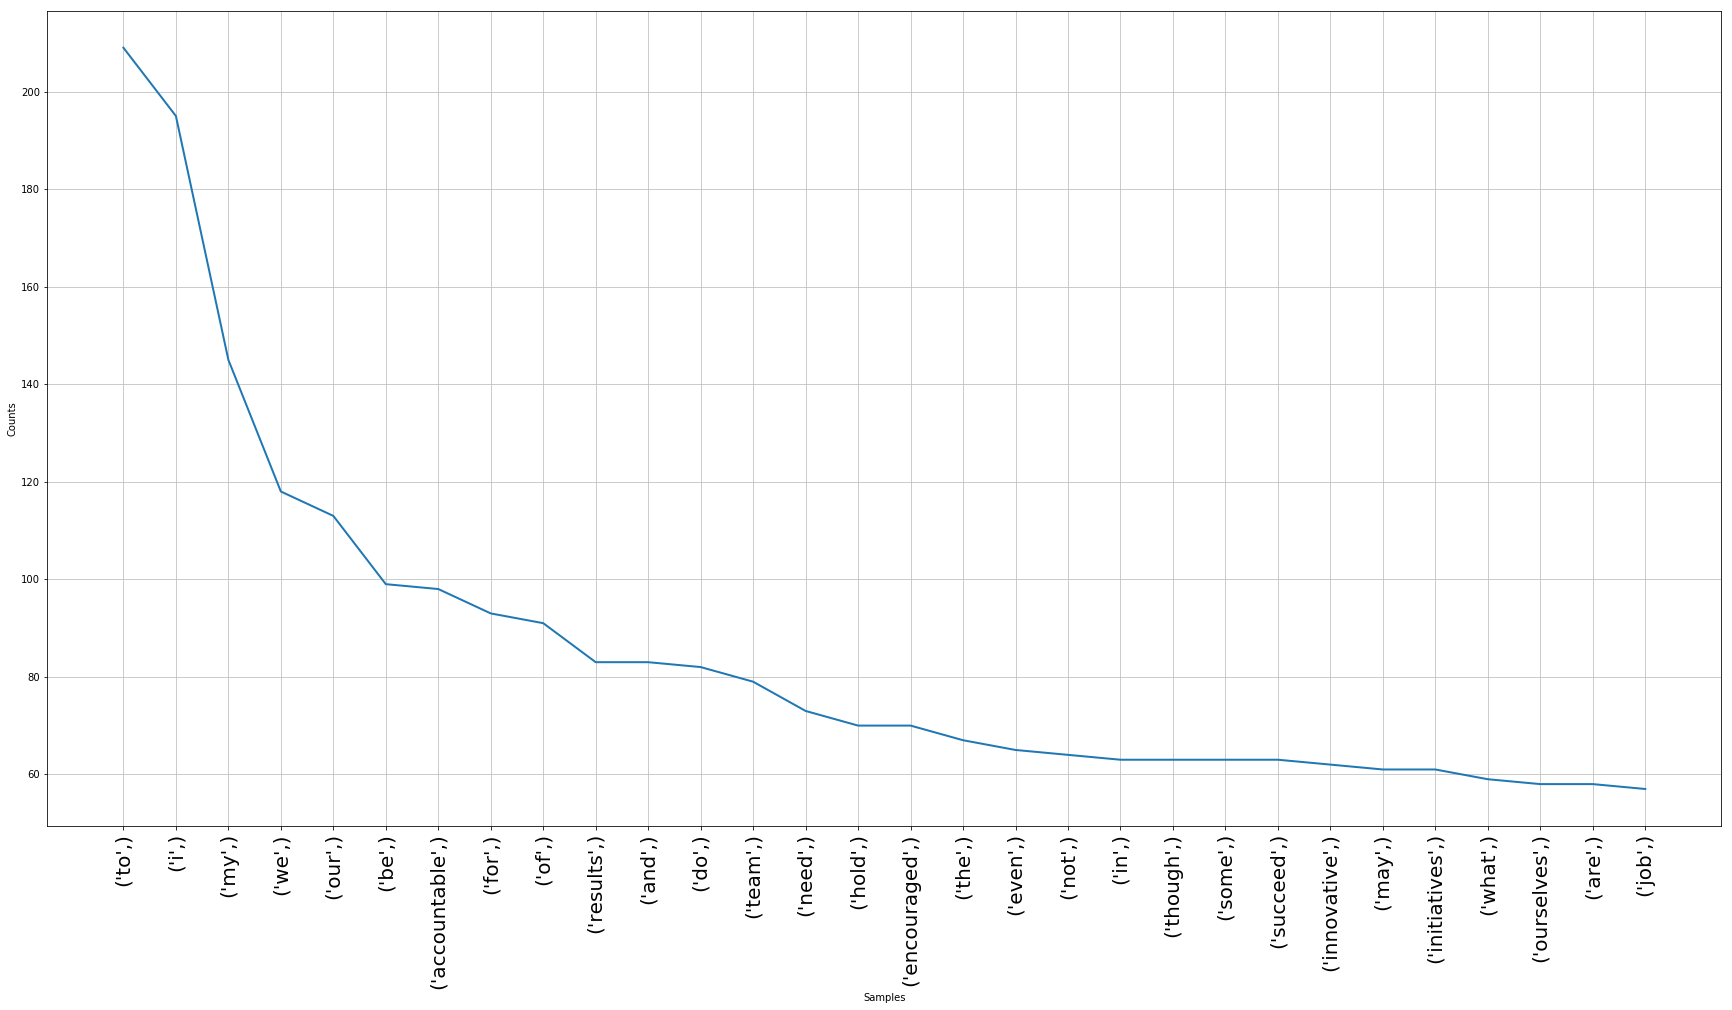

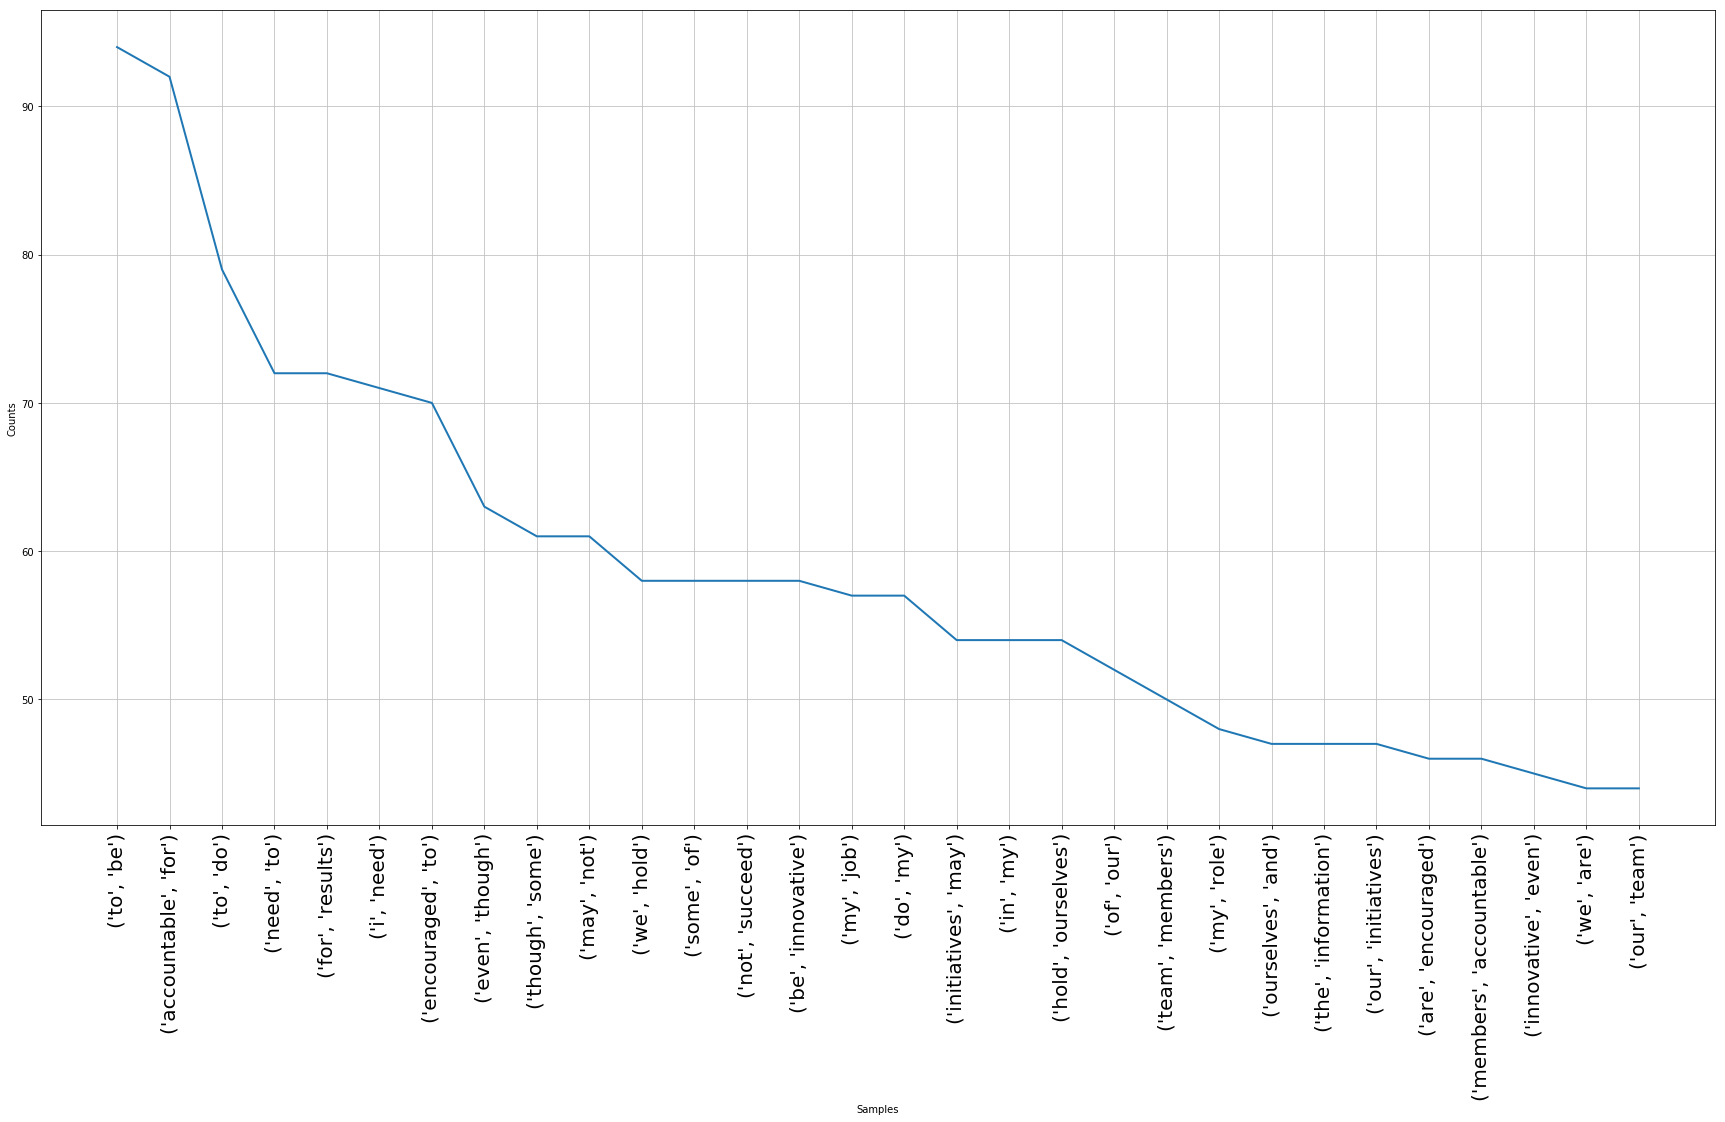

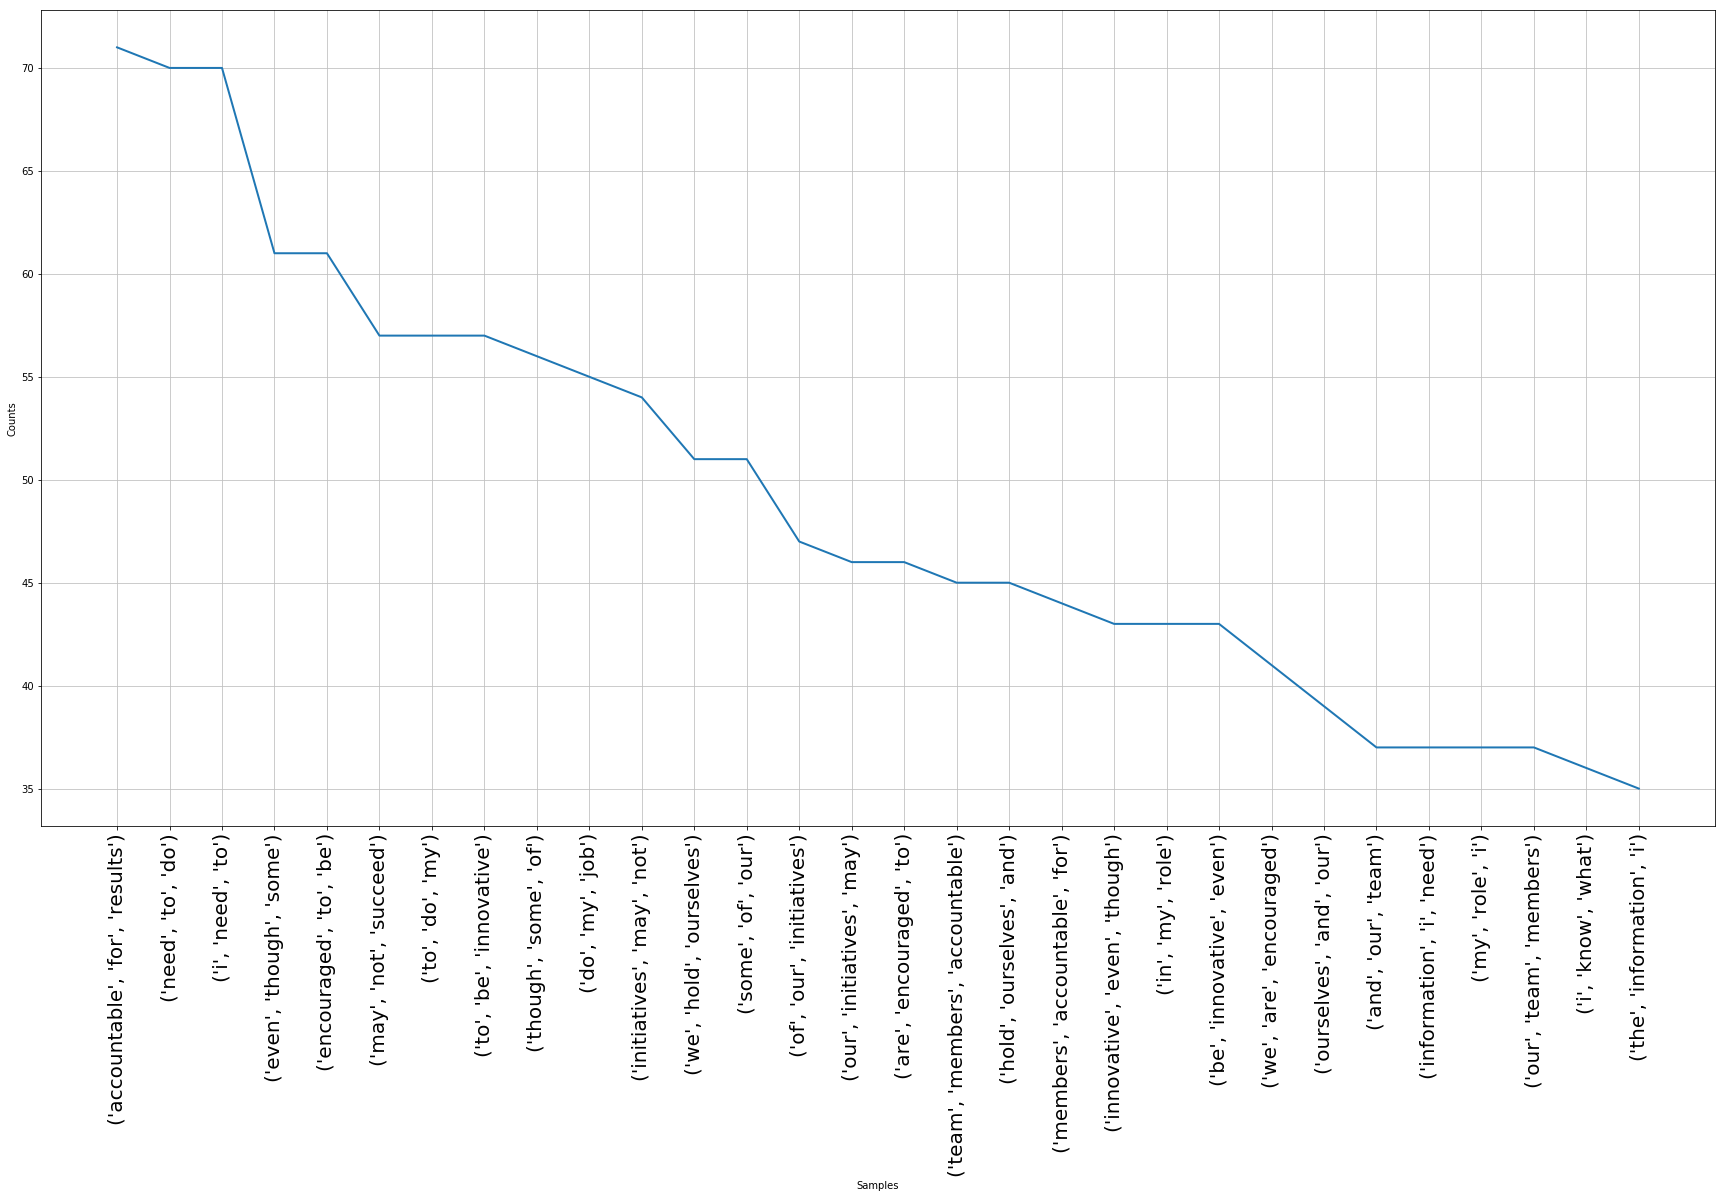

In [7]:
_unigrams = FreqDist(ngrams(_flatBag, n=1))
_unigrams.plot(30)
_bigrams = FreqDist(ngrams(_flatBag, n=2))
_bigrams.plot(30)
_trigrams = FreqDist(ngrams(_flatBag, n=3))
_trigrams.plot(30)

Well certainly looks like 'to' and 'i' seem to be stop-characters. But they seem to be part of alot of bi-grams and tri-grams. Interesting. Let's have a another look at our dataset, to see if we can identify any duplicate questions that may have come up. Actually i did this because i built a couple of simple models which return 100% accuracy after segmenting testing and training sets. Gave me the impression that it's overfitting, which in turn meant that there must be duplicate values which are present in both the testing and training sets.

In [8]:
r_duplicates = _data.drop_duplicates()
print(r_duplicates.shape[0], _data.shape[0])

288 297


Let's have a look at the top 25 records.

In [9]:
r_duplicates.head(25)

,question_text,code
0,i know what my goals are and what i need to do...,ALI.5
1,i feel like i can be successful in my role,ALI.5
2,30. i know what i need to do to be successful ...,ALI.5
3,i understand my role and what is expected of me,ALI.5
4,i know what is expected of me in my role.,ALI.5
5,i understand whatäó»s expected of me.,ALI.5
6,i understand what is expected of me in my role,ALI.5
7,25. i know what i need to do to be successful ...,ALI.5
8,i know what i need to be successful in my role,ALI.5
9,i understand what i need to do to be effective...,ALI.5


Clearly, the duplication in string hasn't worked. This is prettey common with text data, so let's use a more comprehensive processor to identify similarity.

Let's carry out the following tasks.
1. Remove any non alphabetic characters.
2. Stem the words.
3. Drop duplicate again

In [13]:
# Helper function for removing non alphabetic characters.
def removeNonAlphabetic(stringSentence):
    # type: (str) -> str
    """
    This method takes a string sentance and removes any characters that are non alphabetic.
    :param stringSentence:
    :return:
    """
    _tokens = stringSentence.split(' ')
    _realWords = [word for word in _tokens if word.isalpha()]

    return ' '.join(_realWords)

# Helper function for stemming the words.
def stemWords(stringSentence, stemmer):
    # type: (str,object) -> str
    """
    Stems words using a stemmer.
    :param stringSentence: Sentence to be processed.
    :return:
    """

    _tokens = stringSentence.split(' ')

    _tokens = list(map(lambda x: stemmer.stem(x), _tokens))

    return ' '.join(_tokens)

# Remove the non alpha characters.
r_duplicates['question_text'] = r_duplicates['question_text'].apply(lambda x: removeNonAlphabetic(x))
# Stem words
_stemmer = LancasterStemmer()
r_duplicates['question_text'] = r_duplicates['question_text'].apply(lambda x: stemWords(x, _stemmer))

r_duplicates = r_duplicates.drop_duplicates()
print(r_duplicates.shape[0],_data.shape[0])

270 297


Now the dataset is cleaned and ready for the learning algorithm. Let's output and move on to the modelling phase.